In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [39]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.layers import Layer, Input
from keras.layers import Conv2D, Dense, MaxPooling2D, BatchNormalization, Flatten, Dropout, Conv2DTranspose
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model, Sequential
from keras.layers import Concatenate, UpSampling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:

dataset_path = "/content/drive/MyDrive/Semantic segmentation dataset"
dataset_folders = []

for item in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, item)) and item != "classes.json":
        dataset_folders.append(item)

dataset_folders = sorted(dataset_folders)

print("Dataset Structure:")
print("-------------------------")
for idx, folder in enumerate(dataset_folders, 1):
    print(f"{idx}. {folder}")

print("\n Total Number of Portions:", len(dataset_folders))

Dataset Structure:
-------------------------
1. Tile 1
2. Tile 2
3. Tile 3
4. Tile 4
5. Tile 5
6. Tile 6
7. Tile 7
8. Tile 8

 Total Number of Portions: 8


In [4]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img


def loadImg(dataset_path, Tile):
    input_img, mask_img = [], []
    path = os.path.join(dataset_path, Tile)

    if not os.path.exists(path):
        print(f"Directory does not exist: {path}")
        return input_img, mask_img

    try:
        inpDir, maskDir = os.listdir(path)
        print(f"Found directories: {inpDir}, {maskDir}")
    except Exception as e:
        print(f"Error reading directories in path {path}: {e}")
        return input_img, mask_img

    imgDirs = sorted(os.listdir(os.path.join(path, inpDir)))
    mask_imgDirs = sorted(os.listdir(os.path.join(path, maskDir)))

  

    if not imgDirs or not mask_imgDirs:
        print("One or both directories are empty.")
        return input_img, mask_img

    for imgDir in imgDirs:
        imgDirPath = os.path.join(path, inpDir, imgDir)
      
        try:
            img = load_img(imgDirPath, target_size=(224, 224))
            img = tf.convert_to_tensor(img, dtype=tf.float32) / 255.0
            input_img.append(img)
        except Exception as e:
            print(f"Error loading image {imgDirPath}: {e}")

    for mask_imgDir in mask_imgDirs:
        mask_imgDirPath = os.path.join(path, maskDir, mask_imgDir)
        
        try:
            mask = load_img(mask_imgDirPath, target_size=(224, 224))
            mask = tf.convert_to_tensor(mask, dtype=tf.float32) / 255.0
            mask_img.append(mask)
        except Exception as e:
            print(f"Error loading mask {mask_imgDirPath}: {e}")

    print(f"Loaded {len(input_img)} images and {len(mask_img)} masks.")

    return input_img, mask_img


for Tile in dataset_folders:
    print(f"Attempting to load images and masks for: {Tile}")  
    input_img, mask_img = loadImg(dataset_path, Tile)
    print(f"Loaded {len(input_img)} images and {len(mask_img)} masks for {Tile}")


Attempting to load images and masks for: Tile 1
Found directories: masks, images
Loaded 9 images and 9 masks.
Loaded 9 images and 9 masks for Tile 1
Attempting to load images and masks for: Tile 2
Found directories: masks, images
Loaded 9 images and 9 masks.
Loaded 9 images and 9 masks for Tile 2
Attempting to load images and masks for: Tile 3
Found directories: masks, images
Loaded 9 images and 9 masks.
Loaded 9 images and 9 masks for Tile 3
Attempting to load images and masks for: Tile 4
Found directories: images, masks
Loaded 9 images and 9 masks.
Loaded 9 images and 9 masks for Tile 4
Attempting to load images and masks for: Tile 5
Found directories: images, masks
Loaded 9 images and 9 masks.
Loaded 9 images and 9 masks for Tile 5
Attempting to load images and masks for: Tile 6
Found directories: images, masks
Loaded 9 images and 9 masks.
Loaded 9 images and 9 masks for Tile 6
Attempting to load images and masks for: Tile 7
Found directories: masks, images
Loaded 9 images and 9 mas

In [5]:
def loadData(dataset_path, dataset_folders):
    imgs_data, masks_data = [], []
    for Tile in dataset_folders:
        input_imgs, mask_imgs = loadImg(dataset_path, Tile)

        imgs_data.extend(input_imgs)
        masks_data.extend(mask_imgs)
    return imgs_data, masks_data


In [6]:
input_imgs, mask_imgs = loadData(dataset_path, dataset_folders)

Found directories: masks, images
Loaded 9 images and 9 masks.
Found directories: masks, images
Loaded 9 images and 9 masks.
Found directories: masks, images
Loaded 9 images and 9 masks.
Found directories: images, masks
Loaded 9 images and 9 masks.
Found directories: images, masks
Loaded 9 images and 9 masks.
Found directories: images, masks
Loaded 9 images and 9 masks.
Found directories: masks, images
Loaded 9 images and 9 masks.
Found directories: masks, images
Loaded 9 images and 9 masks.


(-0.5, 223.5, 223.5, -0.5)

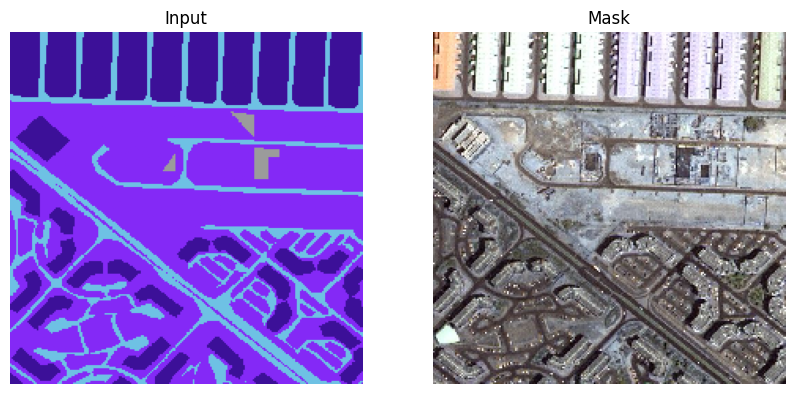

In [7]:
plt.figure(figsize = (10, 6))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(input_imgs[10])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask_imgs[10])
plt.axis("off")

#Train and test split


In [8]:


train_imgs, test_imgs, train_masks, test_masks = train_test_split(input_imgs, mask_imgs,
                                                                  test_size = 0.2,
                                                                  shuffle = True,
                                                                  random_state = 42)

#visualize train image and mask


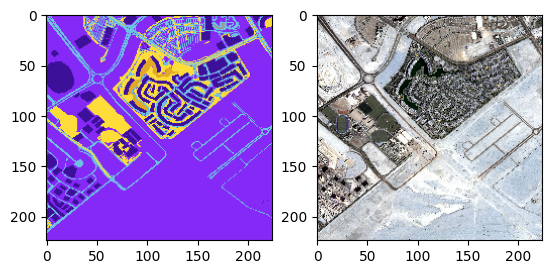

In [9]:
plt.subplot(1, 2, 1)
plt.imshow(train_imgs[1])

plt.subplot(1, 2, 2)
plt.imshow(train_masks[1])

#visualize Test first image and mask

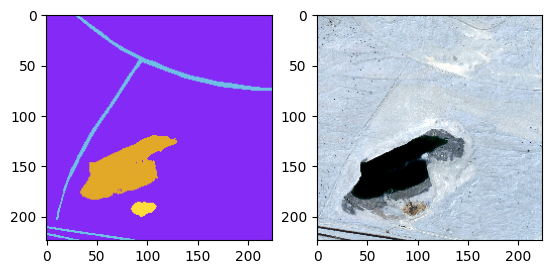

In [10]:
plt.subplot(1, 2, 1)
plt.imshow(test_imgs[1])

plt.subplot(1, 2, 2)
plt.imshow(test_masks[1])

In [11]:
train_data = np.array(list(zip(train_imgs, train_masks)))
test_data = np.array(list(zip(test_imgs, test_masks)))

In [36]:
class AttentionBlock(layers.Layer):
    def __init__(self, filters):
        super(AttentionBlock, self).__init__()
        self.filters = filters

    def build(self, input_shape):

        self.query_conv = layers.Conv2D(self.filters, (1, 1), padding='same')
        self.key_conv = layers.Conv2D(self.filters, (1, 1), padding='same')
        self.value_conv = layers.Conv2D(self.filters, (1, 1), padding='same')
        self.attn_conv = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')

    def call(self, inputs):

        query = self.query_conv(inputs)
        key = self.key_conv(inputs)
        value = self.value_conv(inputs)


        attention_weights = tf.nn.softmax(query * key, axis=-1)


        attended_value = attention_weights * value
        return attended_value


In [38]:

def Conv(x, dropout, filters):
    x = layers.Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    pool = layers.MaxPooling2D(pool_size=(2, 2))(x)
    return x, pool


def UpSample(x, skip_connect, dropout, filters):
    x = layers.Concatenate(axis=-1)([skip_connect, layers.UpSampling2D(size=(2, 2))(x)])
    x = layers.Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    return x


def UNet_with_total_attention(input, dropout, conv=[32, 64, 128, 256, 512]):

    conv1, pool1 = Conv(input, dropout, conv[0])
    conv1 = AttentionBlock(conv[0])(conv1)  
    conv2, pool2 = Conv(pool1, dropout, conv[1])
    conv2 = AttentionBlock(conv[1])(conv2)  
    conv3, pool3 = Conv(pool2, dropout, conv[2])
    conv3 = AttentionBlock(conv[2])(conv3)  
    conv4, pool4 = Conv(pool3, dropout, conv[3])
    conv4 = AttentionBlock(conv[3])(conv4)  
    #bottelneck
    conv5 = layers.Conv2D(filters=conv[4], kernel_size=3, padding='same', activation='relu')(pool4)
    conv5 = layers.Dropout(dropout)(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = AttentionBlock(conv[4])(conv5)  

    # Decoder with Attention
    conv6 = UpSample(conv5, conv4, dropout, conv[4])
    conv6 = AttentionBlock(conv[4])(conv6)  
    conv7 = UpSample(conv6, conv3, dropout, conv[3])
    conv7 = AttentionBlock(conv[3])(conv7)  
    conv8 = UpSample(conv7, conv2, dropout, conv[2])
    conv8 = AttentionBlock(conv[2])(conv8)  
    conv9 = UpSample(conv8, conv1, dropout, conv[1])
    conv9 = AttentionBlock(conv[1])(conv9)  

    # Output layer
    result = layers.Conv2D(filters=3, kernel_size=1, padding='same', activation='sigmoid')(conv9)
    return result

# Build the model
input = layers.Input(shape=(224, 224, 3))
output = UNet_with_total_attention(input, dropout=0.1)

model = models.Model(inputs=input, outputs=output)

model.summary()




Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_108 (Conv2D)       │ (None, 224, 224, 32)   │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 224, 224, 32)   │            128 │ conv2d_108[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_109 (Conv2D)       │ (None, 224, 224, 32)   │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 224, 224, 32)   │              0 │ conv2d_109[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 112, 112, 32)   │              0 │ dropout_18[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_114 (Conv2D)       │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 112, 112, 64)   │            256 │ conv2d_114[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_115 (Conv2D)       │ (None, 112, 112, 64)   │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 112, 112, 64)   │              0 │ conv2d_115[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 56, 56, 64)     │              0 │ dropout_19[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_120 (Conv2D)       │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 56, 56, 128)    │            512 │ conv2d_120[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_121 (Conv2D)       │ (None, 56, 56, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 56, 56, 128)    │              0 │ conv2d_121[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 28, 28, 128)    │              0 │ dropout_20[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 13,067,971 (49.85 MB)

 Trainable params: 13,064,067 (49.84 MB)

 Non-trainable params: 3,904 (15.25 KB)

In [13]:
model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [22]:
import matplotlib.pyplot as plt
import numpy as np

history = model.fit(
    np.array(train_imgs), np.array(train_masks),
    batch_size=8,
    epochs=20,
    validation_data=(np.array(test_imgs), np.array(test_masks))
)





Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - accuracy: 0.6998 - loss: 0.5662 - val_accuracy: 0.5297 - val_loss: 0.6790
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 377ms/step - accuracy: 0.6992 - loss: 0.5604 - val_accuracy: 0.5777 - val_loss: 0.6688
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step - accuracy: 0.7221 - loss: 0.5582 - val_accuracy: 0.5708 - val_loss: 0.6519
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accuracy: 0.7188 - loss: 0.5698 - val_accuracy: 0.5801 - val_loss: 0.6658
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 356ms/step - accuracy: 0.7107 - loss: 0.5606 - val_accuracy: 0.5596 - val_loss: 0.6623
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 358ms/step - accuracy: 0.6967 - loss: 0.5567 - val_accuracy: 0.5696 - val_loss: 0.6624
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 377ms/step - accuracy: 0.7151 - loss: 0.5519 - val_accuracy: 0.5982 - val_loss: 0.6557
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 358ms/step - accuracy: 0.6841 - loss: 0.5635 - val_accuracy: 0.5419 - val_loss:

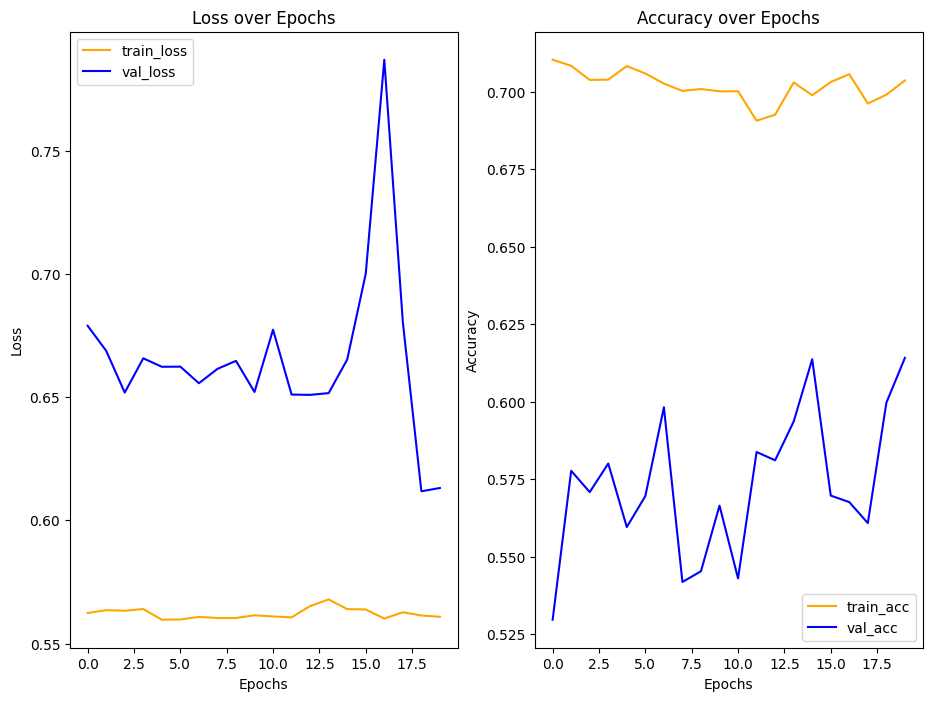

In [24]:
#  history
plt.figure(figsize=(11, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], c='orange', label='train_loss')
plt.plot(history.history['val_loss'], c='blue', label='val_loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#  accuracy history
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], c='orange', label='train_acc')
plt.plot(history.history['val_accuracy'], c='blue', label='val_acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


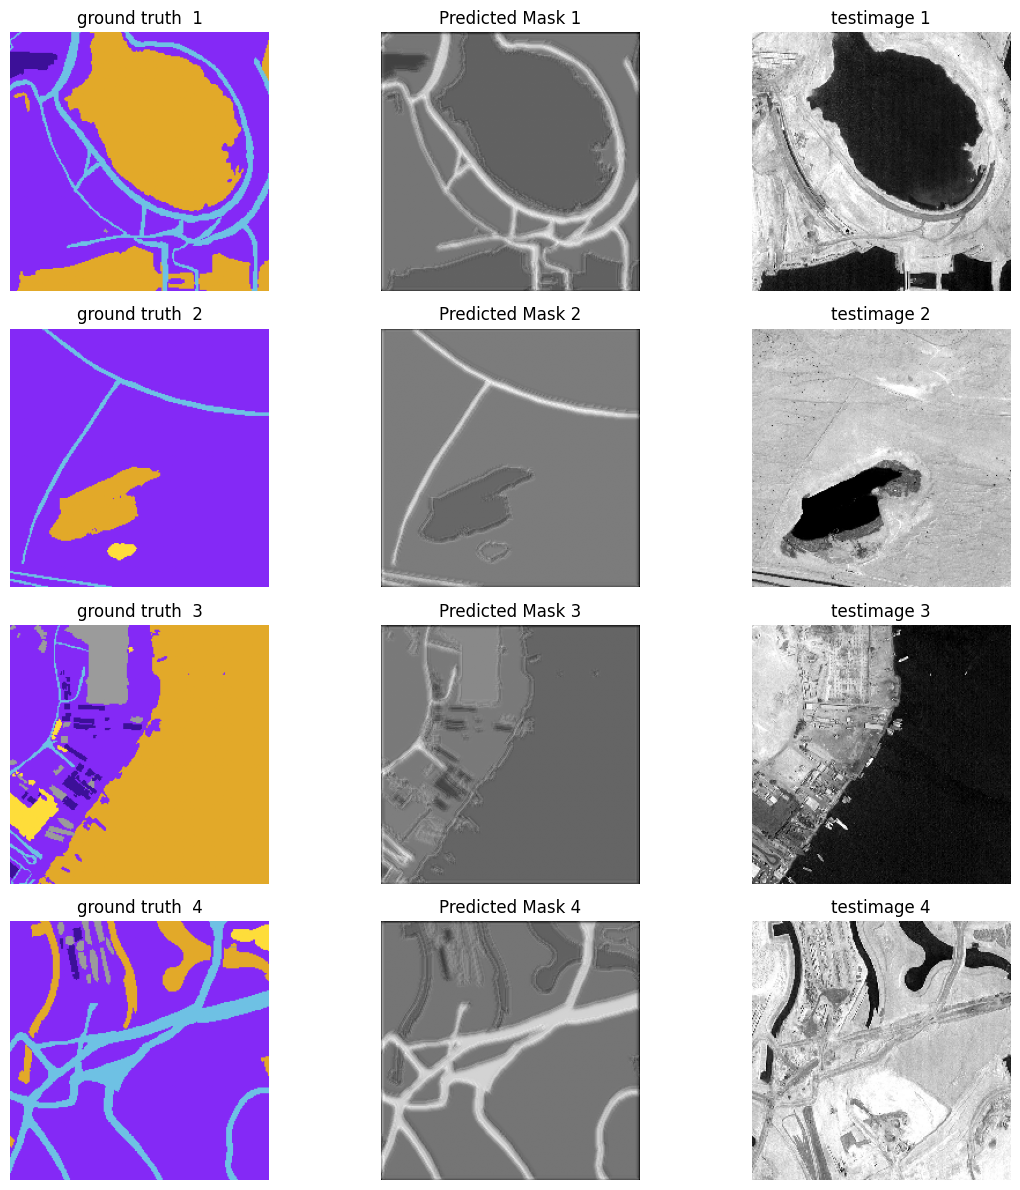

In [42]:

predictions = model.predict(np.array(test_imgs))


test_masks = np.array(test_masks)


plt.figure(figsize=(12, 12))


for id in range(4):

    plt.subplot(4, 3, id * 3 + 1)
    plt.imshow(test_imgs[id])
    plt.title(f'testimage  {id+1}')
    plt.axis('off')

    plt.subplot(4, 3, id * 3 + 2)
    plt.imshow(predictions[id, :, :, 0], cmap='gray')
    plt.title(f'Predicted Mask {id+1}')
    plt.axis('off')


    plt.subplot(4, 3, id * 3 + 3)
    plt.imshow(test_masks[id, :, :, 0], cmap='gray')
    plt.title(f'ground truth {id+1}')
    plt.axis('off')


plt.tight_layout()
plt.show()


predictions_class = np.argmax(predictions, axis=-1)